## Fine-tuning HerBert models and predicting the labels of the paragraphs.

In this file, I show the steps for the fine-tuning the pre-trained HerBert model [(Mroczkowski et al. 2021)](https://huggingface.co/allegro/herbert-base-cased). This notebook was based on the code from the trasformes [documentation](https://huggingface.co/docs/transformers/v4.15.0/custom_datasets) and [examples](https://huggingface.co/docs/transformers/training). The rest of the soruces are mentioned with the codes if necessary.

Please note, this notebook was run using Google Collab and their free GPU. If you wish to re-run this, I would encourage you to do the same.


### 1. Setup

#### 1.1 Downloading necessary packages and data

In [1]:
# packages

!pip install transformers
!pip install sacremoses
!pip install datasets
!pip install tensorflow
!pip install torch
!pip install optuna
!pip install datasets
!pip install googletrans
!pip install sklearn.metrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 25.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 18.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 57.8 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 880.6/880.6 kB 12.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for sacremoses: filename=sacremoses-0.0.53-py3-none-any.whl size=895259 sha256=3ee33542e6d80782c05648179ee907459809262a799b23ff7e2f12fd0cd6e78d
  Stored in directory: /root/.cache/pip/wheels/12/1c/3d/46cf06718d63a32ff798a89594b61e7f345ab6b36d909ce033
Successfully built sacremoses
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 

In [2]:
# imports necessary libraries

import pandas as pd
import datasets
import torch
import time
import random
import numpy as np
import optuna
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from datasets import load_dataset, Dataset, DatasetDict, ClassLabel
from torch.utils.data import Dataset, ConcatDataset, random_split
from torch.optim import SGD
from torch import nn
from transformers import EarlyStoppingCallback, Trainer, TrainingArguments, AutoModelForSequenceClassification, AutoTokenizer,pipeline
from googletrans import Translator
from multiprocessing import Pool, cpu_count
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

In [3]:
# mounts drive

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# loads handcoded data and paragraphs to be labeled

df1=pd.read_csv('/content/drive/MyDrive/labeled_new.csv')
df2 = pd.read_csv('/content/drive/MyDrive/divided.csv')


In [5]:
# adds an index to each paragaph

df1['combined_index'] = df1['index'].astype(str) + '_' + df1['paragraph_number'].astype(str)
df2['combined_index'] = df2['index'].astype(str) + '_' + df2['paragraph_number'].astype(str)

# removes from the dataset to predict later, the lables that were already labelled

ids_to_remove = list(df1['combined_index'])
df2 = df2[~df2['combined_index'].isin(ids_to_remove)]

In [6]:
# creats a map function to add labels to my data

def map_labels(text):
    label = text["populism_full"]
    label_id = int(label)
    return {"labels": label_id, "label_name": label}


In [7]:
# this is to create new columns to check if the above function works correctly

for index, row in df1.iterrows():
    label_dict = map_labels(row)
    label_id = label_dict['labels']
    label_name = label_dict['label_name']
    df1.loc[index, 'label_id'] = label_id
    df1.loc[index, 'label_name'] = label_name

df1

,legislator,name,debate,minister,gov_member,president_office,topic,link,speech,people-centrism,...,date,sejm,party_club_start,party_club_end,change,index,paragraph_number,combined_index,label_id,label_name
0,Stanisław Tyszka,Stanisław Tyszka,6.0,0,0,0,Pierwsze czytanie rządowego projektu ustawy bu...,http://www.sejm.gov.pl/Sejm8.nsf/wypowiedz.xsp...,"Otóż rząd zbiera owoce kampanii wyborczej, gdz...",1,...,29/12/2015,8,Kukiz,Kukiz,0.0,215610,2,215610_2,1.0,1.0
1,Sylwester Chruszcz,Sylwester Chruszcz,25.0,0,0,0,Sprawozdanie Komisji Obrony Narodowej oraz Kom...,http://www.sejm.gov.pl/Sejm8.nsf/wypowiedz.xsp...,Klub Kukiz'15 będzie głosował za przyjęciem te...,0,...,30/11/2016,8,Kukiz,PIS,1.0,226928,0,226928_0,0.0,0.0
2,Beata Szydło,Beata Szydło,NaN,0,0,0,1. Pierwsze czytanie rządowego projektu ustawy...,http://www.sejm.gov.pl/sejm7.nsf/wypowiedz.xsp...,Reformowanie przez likwidowanie to sposób na r...,1,...,23/10/2012,7,PIS,PIS,0.0,182901,22,182901_22,1.0,1.0
3,Barbara Dziuk,Barbara Dziuk,21.0,0,0,0,Przedstawiona przez ministra środowiska inform...,http://www.sejm.gov.pl/Sejm8.nsf/wypowiedz.xsp...,Panie Marszałku! Panie Ministrze! Wysoka Izbo!...,0,...,23/09/2016,8,PIS,PIS,0.0,224267,1,224267_1,0.0,0.0
4,Łukasz Schreiber,Łukasz Schreiber,NaN,0,0,0,1. Pierwsze czytanie poselskiego projektu usta...,http://www.sejm.gov.pl/Sejm8.nsf/wypowiedz.xsp...,Wreszcie czemu ma to być przyjazne dla podatni...,0,...,21/09/2016,8,PIS,PIS,0.0,223921,16,223921_16,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
819,Piotr Ikonowicz,Piotr Ikonowicz,6.0,0,0,0,Sprawozdanie Komisji Nadzwyczajnej do rozpatrz...,http://orka2.sejm.gov.pl/Debata2.nsf/5c30b337b...,"To właśnie politycy, to właśnie hierarchowie k...",1,...,14/09/1995,2,SLD,PPS,1.0,12755,3,12755_3,1.0,1.0
820,Dorota Kwaśniewska,Dorota Kwaśniewska,NaN,0,0,0,11. Pierwsze czytanie poselskiego projektu uch...,http://orka2.sejm.gov.pl/Debata4.nsf/5c30b337b...,Czy rządzenie w Polsce zostało sprowadzone do ...,1,...,29/04/2004,4,Samoobrona,PSL,1.0,93519,8,93519_8,1.0,1.0
821,Piotr Ikonowicz,Piotr Ikonowicz,28.0,0,0,0,˝Polityka prorodzinna państwa˝ (druk nr 1522) ...,http://orka2.sejm.gov.pl/Debata3.nsf/5c30b337b...,"Polska nie jest ani tak biedna, żeby były w ni...",1,...,17/03/2000,3,SLD,NZ,2.0,49316,5,49316_5,1.0,1.0
822,Przemysław Wipler,Przemysław Wipler,5.0,0,0,0,Informacja prokuratora generalnego dotycząca u...,http://www.sejm.gov.pl/sejm7.nsf/wypowiedz.xsp...,A jak pokazują doświadczenia ostatnich dwudzie...,1,...,10/06/2015,7,PIS,NZ,2.0,210036,4,210036_4,1.0,1.0


### 1.2 Data augmentation - back translation

In [ ]:
import pandas as pd
import time
from googletrans import Translator


df_to_translate = df1[df1["label_name"] == 1].copy()
texts_to_translate = df_to_translate["speech"].tolist()


translator = Translator(service_urls=["translate.google.com"])
translated_texts = []
for text in texts_to_translate:
    while True:
        try:
            translation = translator.translate(text, dest="fr")
            back_translation = translator.translate(translation.text, dest="pl")
            translated_texts.append(back_translation.text)
            break
        except:
            time.sleep(5)
            continue

df_to_translate["speech"] = translated_texts
df_to_translate["label_name"] = [1]*len(translated_texts)
augmented_data = pd.concat([df1, df_to_translate], ignore_index=True)

# in order to save time, the data was saved:
# augmented_data.to_csv("/content/drive/MyDrive/augmented_data.csv", index=False)

# SOURCE: https://py-googletrans.readthedocs.io/en/latest/ 
# codes on the website are avaiable under MIT license, the author is SuHun Han (2020)

In [8]:
df_new=pd.read_csv('/content/drive/MyDrive/augmented_data.csv')

In [9]:
df_new

,legislator,name,debate,minister,gov_member,president_office,topic,link,speech,people-centrism,...,date,sejm,party_club_start,party_club_end,change,index,paragraph_number,combined_index,label_id,label_name
0,Stanisław Tyszka,Stanisław Tyszka,6.0,0,0,0,Pierwsze czytanie rządowego projektu ustawy bu...,http://www.sejm.gov.pl/Sejm8.nsf/wypowiedz.xsp...,"Otóż rząd zbiera owoce kampanii wyborczej, gdz...",1,...,29/12/2015,8,Kukiz,Kukiz,0.0,215610,2,215610_2,1.0,1.0
1,Sylwester Chruszcz,Sylwester Chruszcz,25.0,0,0,0,Sprawozdanie Komisji Obrony Narodowej oraz Kom...,http://www.sejm.gov.pl/Sejm8.nsf/wypowiedz.xsp...,Klub Kukiz'15 będzie głosował za przyjęciem te...,0,...,30/11/2016,8,Kukiz,PIS,1.0,226928,0,226928_0,0.0,0.0
2,Beata Szydło,Beata Szydło,NaN,0,0,0,1. Pierwsze czytanie rządowego projektu ustawy...,http://www.sejm.gov.pl/sejm7.nsf/wypowiedz.xsp...,Reformowanie przez likwidowanie to sposób na r...,1,...,23/10/2012,7,PIS,PIS,0.0,182901,22,182901_22,1.0,1.0
3,Barbara Dziuk,Barbara Dziuk,21.0,0,0,0,Przedstawiona przez ministra środowiska inform...,http://www.sejm.gov.pl/Sejm8.nsf/wypowiedz.xsp...,Panie Marszałku! Panie Ministrze! Wysoka Izbo!...,0,...,23/09/2016,8,PIS,PIS,0.0,224267,1,224267_1,0.0,0.0
4,Łukasz Schreiber,Łukasz Schreiber,NaN,0,0,0,1. Pierwsze czytanie poselskiego projektu usta...,http://www.sejm.gov.pl/Sejm8.nsf/wypowiedz.xsp...,Wreszcie czemu ma to być przyjazne dla podatni...,0,...,21/09/2016,8,PIS,PIS,0.0,223921,16,223921_16,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
895,Piotr Ikonowicz,Piotr Ikonowicz,6.0,0,0,0,Sprawozdanie Komisji Nadzwyczajnej do rozpatrz...,http://orka2.sejm.gov.pl/Debata2.nsf/5c30b337b...,To politycy są hierarchami Kościoła i najbardz...,1,...,14/09/1995,2,SLD,PPS,1.0,12755,3,12755_3,1.0,1.0
896,Dorota Kwaśniewska,Dorota Kwaśniewska,NaN,0,0,0,11. Pierwsze czytanie poselskiego projektu uch...,http://orka2.sejm.gov.pl/Debata4.nsf/5c30b337b...,Czy reguła w Polsce przyniosła walki między op...,1,...,29/04/2004,4,Samoobrona,PSL,1.0,93519,8,93519_8,1.0,1.0
897,Piotr Ikonowicz,Piotr Ikonowicz,28.0,0,0,0,˝Polityka prorodzinna państwa˝ (druk nr 1522) ...,http://orka2.sejm.gov.pl/Debata3.nsf/5c30b337b...,"Polska nie jest tak biedna, że ​​było głodne d...",1,...,17/03/2000,3,SLD,NZ,2.0,49316,5,49316_5,1.0,1.0
898,Przemysław Wipler,Przemysław Wipler,5.0,0,0,0,Informacja prokuratora generalnego dotycząca u...,http://www.sejm.gov.pl/sejm7.nsf/wypowiedz.xsp...,I jak pokazują doświadczenia z ostatnich dwudz...,1,...,10/06/2015,7,PIS,NZ,2.0,210036,4,210036_4,1.0,1.0


### 1.3 Spliting the data into train, validation and test sets

In [10]:
df_clean = df_new[["speech", "populism_full"]]

In [11]:
from datasets import Dataset
dataset =  Dataset.from_pandas(df_clean)
dataset = dataset.map(map_labels)
dataset = dataset.shuffle(seed=42)

Map:   0%|          | 0/900 [00:00<?, ? examples/s]

In [12]:
# splits the dataset into train and test sets

train_test_split = dataset.train_test_split(test_size=0.2, seed=42)
train_dataset = train_test_split["train"]
test_dataset = train_test_split["test"]

# splits the train set into train and validation sets

train_val_split = train_dataset.train_test_split(test_size=0.2, seed=42)
train_dataset = train_val_split["train"]
val_dataset = train_val_split["test"]

dataset = {
    "train": train_dataset,
    "validation": val_dataset,
    "test": test_dataset,
}

# converts the dict to a DatasetDict object

dataset_new = DatasetDict(dataset)


In [13]:
dataset_new

DatasetDict({
    train: Dataset({
        features: ['speech', 'populism_full', 'labels', 'label_name'],
        num_rows: 576
    })
    validation: Dataset({
        features: ['speech', 'populism_full', 'labels', 'label_name'],
        num_rows: 144
    })
    test: Dataset({
        features: ['speech', 'populism_full', 'labels', 'label_name'],
        num_rows: 180
    })
})

In [14]:
train_labels = pd.Series(dataset_new["train"]["labels"]).value_counts()
test_labels = pd.Series(dataset_new["test"]["labels"]).value_counts()
validation_labels = pd.Series(dataset_new["validation"]["labels"]).value_counts()

print("Train labels:\n", train_labels)
print("\nTest labels:\n", test_labels)
print("\nValidation labels:\n", validation_labels)

Train labels:
 0    472
1    104
dtype: int64

Test labels:
 0    153
1     27
dtype: int64

Validation labels:
 0    123
1     21
dtype: int64


### 1.4 Adding metrics

In [15]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score,roc_auc_score
import numpy as np
def compute_metrics(p):
   pred, labels = p
   pred = np.argmax(pred, axis=1)
   accuracy = accuracy_score(y_true=labels, y_pred=pred)
   recall = recall_score(y_true=labels, y_pred=pred, average="binary")
   precision = precision_score(y_true=labels, y_pred=pred, average="binary")
   f1 = f1_score(y_true=labels, y_pred=pred)
   auroc = roc_auc_score(y_true=labels, y_score=pred)
   return {"accuracy": accuracy, "precision": precision, "recall": recall, "f1": f1, 'auROC': auroc}

## 2. Fine-tuning the model

In [16]:
    tokenizer = AutoTokenizer.from_pretrained("allegro/herbert-base-cased")
    model_name = "allegro/herbert-base-cased"
    model = AutoModelForSequenceClassification.from_pretrained(model_name)

    # tokenizer function
    def tokenize_function(examples):
        return tokenizer(examples['speech'], padding="max_length", truncation=True, max_length=100)

    tokenized_datasets = dataset_new.map(tokenize_function, batched=True)
    train_dataset = tokenized_datasets["train"].shuffle(seed=42)
    test_dataset = tokenized_datasets["test"].shuffle(seed=42)
    val_dataset = tokenized_datasets["validation"].shuffle(seed=42)
    combined_dataset = datasets.concatenate_datasets([train_dataset, val_dataset])

Some weights of the model checkpoint at allegro/herbert-base-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.sso.sso_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.sso.sso_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification 

Map:   0%|          | 0/576 [00:00<?, ? examples/s]

Map:   0%|          | 0/144 [00:00<?, ? examples/s]

Map:   0%|          | 0/180 [00:00<?, ? examples/s]

### 2.1 Selecting best parameters

In [17]:
def objective(trial):
    # dropout layers
    dropout_prob = trial.suggest_uniform('dropout_prob', 0.8, 0.9)
    model.classifier.dropout = nn.Dropout(p=dropout_prob)
    model.bert.pooler.dropout = nn.Dropout(p=dropout_prob)

    # misclassification costs
    class_weights = torch.tensor([1.0, 2]).to(model.device)

    # loss function
    loss_fn = torch.nn.CrossEntropyLoss(weight=class_weights)

    # optimizer
    lr = trial.suggest_loguniform('lr',1e-3, 1e-2)
    weight_decay = trial.suggest_loguniform('weight_decay', 0.4, 0.5)
    optimizer = SGD(model.parameters(), lr=lr, weight_decay=weight_decay)

    # early stopping parameters
    early_stopping_patience = 2
    early_stopping_threshold = 0.01
    early_stopping = EarlyStoppingCallback(early_stopping_patience=early_stopping_patience, early_stopping_threshold=early_stopping_threshold)

    # training arguments
    batch_size = 32
    num_train_epochs = 7
    logging_steps = len(train_dataset) // (batch_size * num_train_epochs)

    training_arguments = TrainingArguments(
        output_dir="./models/"+f"{model_name}-finetuned",
        overwrite_output_dir=True, 
        evaluation_strategy="epoch",
        save_strategy="epoch",
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        num_train_epochs=num_train_epochs,
        logging_steps=logging_steps,
        load_best_model_at_end=True
    )

    # trainer
    trainer = Trainer(
        model,
        training_arguments,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        tokenizer=tokenizer,
        compute_metrics=compute_metrics,
        callbacks=[early_stopping]
    )

    
    trainer.train()

    # evaluate on validation set
    result = trainer.evaluate(val_dataset)
    return result['eval_f1']

# set random seed for reproducibility
#random.seed(42)
#np.random.seed(42)
#torch.manual_seed(42)
#torch.cuda.manual_seed_all(42)

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

# print best trial
print("Best trial:")
trial = study.best


[I 2023-04-25 18:37:35,677] A new study created in memory with name: no-name-60f8c9b3-a58a-4f67-8ade-7fea5ef35941


Some weights of the model checkpoint at allegro/herbert-base-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.sso.sso_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.sso.sso_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification 

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Auroc
1,0.385700,0.281186,0.888889,1.000000,0.238095,0.384615,0.619048
2,0.152400,0.210318,0.930556,0.789474,0.714286,0.750000,0.840883
3,0.119400,0.331628,0.916667,0.666667,0.857143,0.750000,0.891986
4,0.001800,0.438301,0.923611,0.777778,0.666667,0.717949,0.817073


[I 2023-04-25 18:39:02,297] Trial 0 finished with value: 0.7500000000000001 and parameters: {'dropout_prob': 0.8827988827841774, 'lr': 0.003883231573068921, 'weight_decay': 0.472052429345575}. Best is trial 0 with value: 0.7500000000000001.
Some weights of the model checkpoint at allegro/herbert-base-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.sso.sso_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.sso.sso_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Ber

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Auroc
1,0.331700,0.249301,0.930556,1.000000,0.523810,0.687500,0.761905
2,0.197800,0.219127,0.888889,0.600000,0.714286,0.652174,0.816492
3,0.238200,0.351107,0.909722,0.900000,0.428571,0.580645,0.710221
4,0.007400,0.326443,0.923611,0.750000,0.714286,0.731707,0.836818


[I 2023-04-25 18:40:16,708] Trial 1 finished with value: 0.6521739130434783 and parameters: {'dropout_prob': 0.8601055159672497, 'lr': 0.004340031787201867, 'weight_decay': 0.4565943495248806}. Best is trial 0 with value: 0.7500000000000001.
Some weights of the model checkpoint at allegro/herbert-base-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.sso.sso_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.sso.sso_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Be

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Auroc
1,0.331700,0.249301,0.930556,1.000000,0.523810,0.687500,0.761905
2,0.197800,0.219127,0.888889,0.600000,0.714286,0.652174,0.816492
3,0.238200,0.351107,0.909722,0.900000,0.428571,0.580645,0.710221
4,0.007400,0.326443,0.923611,0.750000,0.714286,0.731707,0.836818


[I 2023-04-25 18:41:30,440] Trial 2 finished with value: 0.6521739130434783 and parameters: {'dropout_prob': 0.8605308947038319, 'lr': 0.0028922118682446936, 'weight_decay': 0.42843869037064775}. Best is trial 0 with value: 0.7500000000000001.
Some weights of the model checkpoint at allegro/herbert-base-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.sso.sso_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.sso.sso_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing 

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Auroc
1,0.331700,0.249301,0.930556,1.000000,0.523810,0.687500,0.761905
2,0.197800,0.219127,0.888889,0.600000,0.714286,0.652174,0.816492
3,0.238200,0.351107,0.909722,0.900000,0.428571,0.580645,0.710221
4,0.007400,0.326443,0.923611,0.750000,0.714286,0.731707,0.836818


[W 2023-04-25 18:42:40,031] Trial 3 failed with parameters: {'dropout_prob': 0.8987696587094905, 'lr': 0.002052842988555963, 'weight_decay': 0.41821501349168655} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "<ipython-input-17-78a56c0f9616>", line 55, in objective
    trainer.train()
  File "/usr/local/lib/python3.9/dist-packages/transformers/trainer.py", line 1662, in train
    return inner_training_loop(
  File "/usr/local/lib/python3.9/dist-packages/transformers/trainer.py", line 2021, in _inner_training_loop
    self._maybe_log_save_evaluate(tr_loss, model, trial, epoch, ignore_keys_for_eval)
  File "/usr/local/lib/python3.9/dist-packages/transformers/trainer.py", line 2291, in _maybe_log_save_evaluate
    self._save_checkpoint(model, trial, metrics=metrics)
  File "/usr/local/lib/python3.9/dist-package

KeyboardInterrupt: ignored

### 2.2 stratified k-fold cross validation

In [20]:
# note: you might notice, that the parapeters are slighty differet then above, 
# this is due to accidental re-run of the above code from my side after dowloading the file
# the model was trained on the following parameters that were obtained in the initial hyper-parameter tuning

model_name = "allegro/herbert-base-cased"
model = AutoModelForSequenceClassification.from_pretrained(model_name)

combined_labels = [int(label) for label in combined_dataset["label_name"]]

skf = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)

dropout_prob = 0.882 
model.classifier.dropout = nn.Dropout(p=dropout_prob)
model.bert.pooler.dropout = nn.Dropout(p=dropout_prob)

class_weights = torch.tensor([1.0, 2]).to(model.device)

loss_fn = torch.nn.CrossEntropyLoss(weight=class_weights)
optimizer = SGD(model.parameters(), lr=0.006, weight_decay=0.465) 

early_stopping_patience = 2
early_stopping_threshold = 0.01
early_stopping = EarlyStoppingCallback(early_stopping_patience=early_stopping_patience, early_stopping_threshold=early_stopping_threshold)

batch_size = 32
num_train_epochs = 10
logging_steps = len(combined_dataset) // (batch_size * num_train_epochs)

training_arguments = TrainingArguments(
    output_dir="./models/"+f"{model_name}-cv",
    overwrite_output_dir=True, 
    evaluation_strategy="epoch",
    save_strategy="epoch",
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=num_train_epochs,
    logging_steps=logging_steps,
    load_best_model_at_end=True
)

# iterates over the folds
from collections import defaultdict
results = defaultdict(list)

for fold, (train_indices, val_indices) in enumerate(skf.split(combined_dataset, combined_labels)):
    print(f"Fold {fold+1}")
    print("Training...")
    train_dataset_fold = combined_dataset.select(train_indices)
    eval_dataset_fold = combined_dataset.select(val_indices)
    trainer = Trainer(
        model=model, 
        args=training_arguments, 
        train_dataset=train_dataset_fold, 
        eval_dataset=eval_dataset_fold,
        compute_metrics=compute_metrics,
        callbacks=[early_stopping])
    trainer.train()
    evaluation=trainer.evaluate()
    print()

    for key, value in evaluation.items():
        results[key].append(value)

mean_results = {}
for key, value in results.items():
    mean_results[key] = np.mean(value)
    
print(mean_results)

# some basic ideas: 
# https://discuss.huggingface.co/t/k-fold-cross-validation/5765/6 
# https://www.philschmid.de/k-fold-as-cross-validation-with-a-bert-text-classification-example
# https://github.com/christianversloot/machine-learning-articles/blob/main/how-to-use-k-fold-cross-validation-with-pytorch.md

Some weights of the model checkpoint at allegro/herbert-base-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.sso.sso_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.sso.sso_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification 

Fold 1
Training...


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Auroc
1,0.430800,0.388241,0.827778,1.000000,0.031250,0.060606,0.515625
2,0.288500,0.361892,0.877778,1.000000,0.312500,0.476190,0.656250
3,0.306700,0.212804,0.916667,0.814815,0.687500,0.745763,0.826858
4,0.076900,0.251653,0.916667,0.904762,0.593750,0.716981,0.790118
5,0.013300,0.229730,0.922222,0.875000,0.656250,0.750000,0.817990



Fold 2
Training...


/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Auroc
1,0.133600,0.203261,0.905556,1.000000,0.451613,0.622222,0.725806
2,0.122900,0.156202,0.961111,1.000000,0.774194,0.872727,0.887097
3,0.013300,0.230532,0.944444,1.000000,0.677419,0.807692,0.838710
4,0.030600,0.147418,0.977778,1.000000,0.870968,0.931034,0.935484



Fold 3
Training...


/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Auroc
1,0.017600,0.026607,0.988889,1.000000,0.935484,0.966667,0.967742
2,0.001100,0.025672,0.994444,1.000000,0.967742,0.983607,0.983871
3,0.001400,0.064644,0.983333,1.000000,0.903226,0.949153,0.951613



Fold 4
Training...


/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Auroc
1,0.002000,0.002773,1.000000,1.000000,1.000000,1.000000,1.000000
2,0.000500,0.000365,1.000000,1.000000,1.000000,1.000000,1.000000
3,0.000300,0.000163,1.000000,1.000000,1.000000,1.000000,1.000000



{'eval_loss': 0.09651425943229697, 'eval_accuracy': 0.9722222222222222, 'eval_precision': 0.9537037037037037, 'eval_recall': 0.8815524193548387, 'eval_f1': 0.9151009380000191, 'eval_auROC': 0.9365532367044465, 'eval_runtime': 1.0881, 'eval_samples_per_second': 165.66025, 'eval_steps_per_second': 5.522, 'epoch': 3.75}


### 2.3 Retraining on the whole train data with final parameters

In [21]:
# to allow reproducibility
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed_all(42)

model_name = "allegro/herbert-base-cased"
model = AutoModelForSequenceClassification.from_pretrained(model_name)

dropout_prob = 0.882
model.classifier.dropout = nn.Dropout(p=dropout_prob)
model.bert.pooler.dropout = nn.Dropout(p=dropout_prob)

class_weights = torch.tensor([1.0, 2]).to(model.device)

loss_fn = torch.nn.CrossEntropyLoss(weight=class_weights)
optimizer = SGD(model.parameters(), lr=0.006, weight_decay=0.465)

early_stopping = EarlyStoppingCallback(early_stopping_patience=1, early_stopping_threshold=0.01)

batch_size = 32
num_train_epochs = 10
logging_steps = len(train_dataset) // (batch_size * num_train_epochs)

training_arguments = TrainingArguments(
    output_dir="./models/"+f"{model_name}-finetuned",
    overwrite_output_dir=True, 
    evaluation_strategy="epoch",
    save_strategy="epoch",
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=num_train_epochs,
    logging_steps=logging_steps,
    load_best_model_at_end=True
)

trainer = Trainer(
    model,
    training_arguments,
    train_dataset=combined_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[early_stopping]
)


Some weights of the model checkpoint at allegro/herbert-base-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.sso.sso_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.sso.sso_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification 

In [22]:
trainer.train()

/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
You're using a HerbertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Auroc
1,0.353300,0.292653,0.883333,0.687500,0.407407,0.511628,0.687364
2,0.153300,0.215020,0.927778,0.769231,0.740741,0.754717,0.850763
3,0.009200,0.331294,0.905556,0.916667,0.407407,0.564103,0.700436


TrainOutput(global_step=69, training_loss=0.26253060479580925, metrics={'train_runtime': 61.9209, 'train_samples_per_second': 116.277, 'train_steps_per_second': 3.714, 'total_flos': 110999976480000.0, 'train_loss': 0.26253060479580925, 'epoch': 3.0})

In [23]:
trainer.evaluate(test_dataset)

{'eval_loss': 0.21501953899860382,
 'eval_accuracy': 0.9277777777777778,
 'eval_precision': 0.7692307692307693,
 'eval_recall': 0.7407407407407407,
 'eval_f1': 0.7547169811320754,
 'eval_auROC': 0.8507625272331154,
 'eval_runtime': 1.0797,
 'eval_samples_per_second': 166.714,
 'eval_steps_per_second': 5.557,
 'epoch': 3.0}

In [24]:
trainer.predict(test_dataset)

PredictionOutput(predictions=array([[ 2.4047644 , -2.4611866 ],
       [ 2.5560925 , -2.8597517 ],
       [ 2.5798132 , -2.8508427 ],
       [ 2.5180767 , -2.862057  ],
       [ 2.434097  , -2.8359916 ],
       [ 2.1435888 , -2.368995  ],
       [ 2.4412096 , -2.7214441 ],
       [ 2.200484  , -2.4508295 ],
       [ 2.431566  , -2.625744  ],
       [ 0.07195751, -0.271686  ],
       [ 0.997511  , -0.709337  ],
       [ 2.4290984 , -2.7972271 ],
       [ 2.212802  , -2.7128227 ],
       [ 2.0774465 , -2.2988813 ],
       [-1.2425609 ,  1.0491701 ],
       [ 1.7171657 , -1.8046786 ],
       [ 2.4188893 , -2.7157636 ],
       [ 0.03072873, -0.02829358],
       [ 2.3424847 , -2.6316898 ],
       [ 1.0399023 , -1.2628479 ],
       [ 2.335726  , -2.630853  ],
       [ 2.50865   , -2.769047  ],
       [-0.8108103 ,  0.6222278 ],
       [ 2.3881042 , -2.785944  ],
       [ 1.5643618 , -1.5036645 ],
       [ 2.3759773 , -2.7252223 ],
       [ 2.3239238 , -2.6779559 ],
       [ 2.5195842 , -2.92

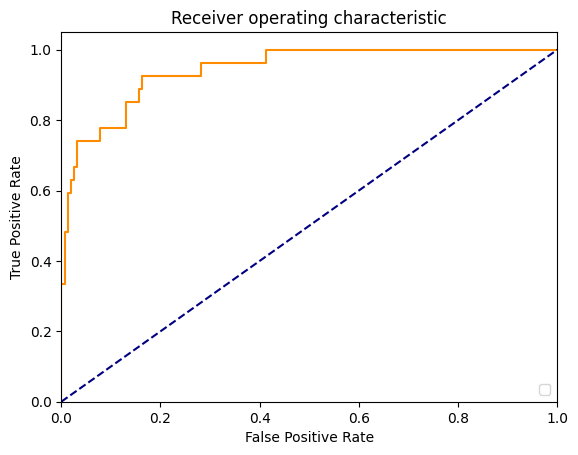

<Figure size 640x480 with 0 Axes>

In [25]:
predictions, labels, _ = trainer.predict(test_dataset)
probabilities = torch.softmax(torch.from_numpy(predictions), dim=1)
probabilities = probabilities[:, 1].numpy()
labels = labels.astype(int)

# false positive rate (fpr), true positive rate (tpr), and area under the curve (auc)
fpr, tpr, thresholds = roc_curve(labels, probabilities)
roc_auc = auc(fpr, tpr)

# ROC plot
fig, ax = plt.subplots()
plt.plot(fpr, tpr, color='darkorange')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

plt.savefig("/content/drive/MyDrive/roc_curve.png")
plt.show()


In [ ]:
# saves the model and tokenizer
trainer.save_model("/content/drive/MyDrive/fine_tuned_model")
tokenizer.save_pretrained("/content/drive/MyDrive/my_tokenizer")

('/content/drive/MyDrive/my_tokenizer/tokenizer_config.json',
 '/content/drive/MyDrive/my_tokenizer/special_tokens_map.json',
 '/content/drive/MyDrive/my_tokenizer/vocab.json',
 '/content/drive/MyDrive/my_tokenizer/merges.txt',
 '/content/drive/MyDrive/my_tokenizer/added_tokens.json',
 '/content/drive/MyDrive/my_tokenizer/tokenizer.json')

### 2.4 Predicting with the model

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

model_path = "/content/drive/MyDrive/fine_tuned_model"
tokenizer_path = "/content/drive/MyDrive/my_tokenizer"

model_saved = AutoModelForSequenceClassification.from_pretrained(model_path)
tokenizer = AutoTokenizer.from_pretrained(tokenizer_path)

classifier = pipeline('text-classification', model=model_saved, tokenizer=tokenizer, device=0 if device.type == "cuda" else -1)

Using device: cuda


/usr/local/lib/python3.9/dist-packages/transformers/pipelines/base.py:1070: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


In [ ]:
# examples
classifier(["Elity są przeciwko obywatelom", "Rząd okrada Polaków", "Do gabinetów lekarzy różnych specjalizacji często przychodzą pacjenci z objawami, których nie można powiązać z niczym innym niż przebytą infekcją."])

/usr/local/lib/python3.9/dist-packages/transformers/pipelines/base.py:1070: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


[{'label': 'LABEL_1', 'score': 0.7802611589431763},
 {'label': 'LABEL_1', 'score': 0.8128565549850464},
 {'label': 'LABEL_0', 'score': 0.9465801119804382}]

In [ ]:
# in order to predict the labels, but to make sure I do not run out of the memory on Collab, the dataset was divided into smaller batches, 
#predicted and merged afterwards

num_rows = len(df2)
batch_size = num_rows // 50

for i in range(50):
    start = i * batch_size
    end = (i + 1) * batch_size
    batch_df = df2.iloc[start:end]
    batch_df.to_csv(f'/content/drive/MyDrive/batch_{i+1}.csv', index=False)


In [ ]:
for i in range(1,5):
    batch = pd.read_csv(f"/content/drive/MyDrive/batch_{i}.csv")
    predictions = batch["speech"].map(lambda text: classifier(text)[0])
    batch["predicted_label"] = [p["label"] for p in predictions]
    batch["label_number"] = batch["predicted_label"].str.extract('(\d+)', expand=False).astype(int)
    batch.to_csv(f'/content/drive/MyDrive/batch_{i}_predicted.csv', encoding='utf-8', index=False)

In [ ]:
for i in range(5,10):
    batch = pd.read_csv(f"/content/drive/MyDrive/batch_{i}.csv")
    predictions = batch["speech"].map(lambda text: classifier(text)[0])
    batch["predicted_label"] = [p["label"] for p in predictions]
    batch["label_number"] = batch["predicted_label"].str.extract('(\d+)', expand=False).astype(int)
    batch.to_csv(f'/content/drive/MyDrive/batch_{i}_predicted.csv', encoding='utf-8', index=False)


/usr/local/lib/python3.9/dist-packages/transformers/pipelines/base.py:1070: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/transformers/pipelines/base.py:1070: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/transformers/pipelines/base.py:1070: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


In [ ]:
for i in range(10, 15):
    batch = pd.read_csv(f"/content/drive/MyDrive/batch_{i}.csv")
    predictions = batch["speech"].map(lambda text: classifier(text)[0])
    batch["predicted_label"] = [p["label"] for p in predictions]
    batch["label_number"] = batch["predicted_label"].str.extract('(\d+)', expand=False).astype(int)
    batch.to_csv(f'/content/drive/MyDrive/batch_{i}_predicted.csv', encoding='utf-8', index=False)

/usr/local/lib/python3.9/dist-packages/transformers/pipelines/base.py:1070: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/transformers/pipelines/base.py:1070: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/transformers/pipelines/base.py:1070: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/transformers/pipelines/base.py:1070: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/transformers/pipelines/base.py:1070: UserWarning: You seem to be using the pipelines sequentially on 

In [ ]:
for i in range(15, 20):
    batch = pd.read_csv(f"/content/drive/MyDrive/batch_{i}.csv")
    predictions = batch["speech"].map(lambda text: classifier(text)[0])
    batch["predicted_label"] = [p["label"] for p in predictions]
    batch["label_number"] = batch["predicted_label"].str.extract('(\d+)', expand=False).astype(int)
    batch.to_csv(f'/content/drive/MyDrive/batch_{i}_predicted.csv', encoding='utf-8', index=False)

/usr/local/lib/python3.9/dist-packages/transformers/pipelines/base.py:1070: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/transformers/pipelines/base.py:1070: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/transformers/pipelines/base.py:1070: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/transformers/pipelines/base.py:1070: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/transformers/pipelines/base.py:1070: UserWarning: You seem to be using the pipelines sequentially on 

In [ ]:
for i in range(20, 25):
    batch = pd.read_csv(f"/content/drive/MyDrive/batch_{i}.csv")
    predictions = batch["speech"].map(lambda text: classifier(text)[0])
    batch["predicted_label"] = [p["label"] for p in predictions]
    batch["label_number"] = batch["predicted_label"].str.extract('(\d+)', expand=False).astype(int)
    batch.to_csv(f'/content/drive/MyDrive/batch_{i}_predicted.csv', encoding='utf-8', index=False)

/usr/local/lib/python3.9/dist-packages/transformers/pipelines/base.py:1070: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/transformers/pipelines/base.py:1070: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/transformers/pipelines/base.py:1070: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/transformers/pipelines/base.py:1070: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/transformers/pipelines/base.py:1070: UserWarning: You seem to be using the pipelines sequentially on 

In [ ]:
for i in range(25, 30):
    batch = pd.read_csv(f"/content/drive/MyDrive/batch_{i}.csv")
    predictions = batch["speech"].map(lambda text: classifier(text)[0])
    batch["predicted_label"] = [p["label"] for p in predictions]
    batch["label_number"] = batch["predicted_label"].str.extract('(\d+)', expand=False).astype(int)
    batch.to_csv(f'/content/drive/MyDrive/batch_{i}_predicted.csv', encoding='utf-8', index=False)

/usr/local/lib/python3.9/dist-packages/transformers/pipelines/base.py:1070: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/transformers/pipelines/base.py:1070: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/transformers/pipelines/base.py:1070: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/transformers/pipelines/base.py:1070: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/transformers/pipelines/base.py:1070: UserWarning: You seem to be using the pipelines sequentially on 

In [ ]:
for i in range(30, 35):
    batch = pd.read_csv(f"/content/drive/MyDrive/batch_{i}.csv")
    predictions = batch["speech"].map(lambda text: classifier(text)[0])
    batch["predicted_label"] = [p["label"] for p in predictions]
    batch["label_number"] = batch["predicted_label"].str.extract('(\d+)', expand=False).astype(int)
    batch.to_csv(f'/content/drive/MyDrive/batch_{i}_predicted.csv', encoding='utf-8', index=False)

/usr/local/lib/python3.9/dist-packages/transformers/pipelines/base.py:1070: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/transformers/pipelines/base.py:1070: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/transformers/pipelines/base.py:1070: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/transformers/pipelines/base.py:1070: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/transformers/pipelines/base.py:1070: UserWarning: You seem to be using the pipelines sequentially on 

In [ ]:
for i in range(35, 40):
    batch = pd.read_csv(f"/content/drive/MyDrive/batch_{i}.csv")
    predictions = batch["speech"].map(lambda text: classifier(text)[0])
    batch["predicted_label"] = [p["label"] for p in predictions]
    batch["label_number"] = batch["predicted_label"].str.extract('(\d+)', expand=False).astype(int)
    batch.to_csv(f'/content/drive/MyDrive/batch_{i}_predicted.csv', encoding='utf-8', index=False)

/usr/local/lib/python3.9/dist-packages/transformers/pipelines/base.py:1070: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/transformers/pipelines/base.py:1070: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/transformers/pipelines/base.py:1070: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/transformers/pipelines/base.py:1070: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/transformers/pipelines/base.py:1070: UserWarning: You seem to be using the pipelines sequentially on 

In [ ]:
for i in range(40, 45):
    batch = pd.read_csv(f"/content/drive/MyDrive/batch_{i}.csv")
    predictions = batch["speech"].map(lambda text: classifier(text)[0])
    batch["predicted_label"] = [p["label"] for p in predictions]
    batch["label_number"] = batch["predicted_label"].str.extract('(\d+)', expand=False).astype(int)
    batch.to_csv(f'/content/drive/MyDrive/batch_{i}_predicted.csv', encoding='utf-8', index=False)

/usr/local/lib/python3.9/dist-packages/transformers/pipelines/base.py:1070: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/transformers/pipelines/base.py:1070: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/transformers/pipelines/base.py:1070: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/transformers/pipelines/base.py:1070: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/transformers/pipelines/base.py:1070: UserWarning: You seem to be using the pipelines sequentially on 

In [ ]:
for i in range(45, 50):
    batch = pd.read_csv(f"/content/drive/MyDrive/batch_{i}.csv")
    predictions = batch["speech"].map(lambda text: classifier(text)[0])
    batch["predicted_label"] = [p["label"] for p in predictions]
    batch["label_number"] = batch["predicted_label"].str.extract('(\d+)', expand=False).astype(int)
    batch.to_csv(f'/content/drive/MyDrive/batch_{i}_predicted.csv', encoding='utf-8', index=False)

/usr/local/lib/python3.9/dist-packages/transformers/pipelines/base.py:1070: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/transformers/pipelines/base.py:1070: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/transformers/pipelines/base.py:1070: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/transformers/pipelines/base.py:1070: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/transformers/pipelines/base.py:1070: UserWarning: You seem to be using the pipelines sequentially on 

In [ ]:
batch_50= pd.read_csv("/content/drive/MyDrive/batch_50.csv")
predictions = batch_50["speech"].map(lambda text: classifier(text)[0])
batch_50["predicted_label"] = [p["label"] for p in predictions]
batch_50["label_number"] = batch_50["predicted_label"].str.extract('(\d+)', expand=False).astype(int)

batch_50.to_csv('/content/drive/MyDrive/batch_50_predicted.csv', encoding='utf-8', index=False)

/usr/local/lib/python3.9/dist-packages/transformers/pipelines/base.py:1070: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


In [ ]:
dfs = []

for i in range(1, 51):
    file_path = f'/content/drive/MyDrive/batch_{i}_predicted.csv'
    dfs.append(pd.read_csv(file_path))

merged_df = pd.concat(dfs, ignore_index=True)
merged_df.to_csv('/content/drive/MyDrive/all_batches_predicted.csv', encoding='utf-8', index=False)


In [ ]:
all_predicted= pd.read_csv("/content/drive/MyDrive/all_batches_predicted.csv")

In [ ]:
all_predicted

,legislator,name,debate,minister,gov_member,president_office,topic,link,speech,session,date,sejm,party_club_start,party_club_end,change,index,paragraph_number,combined_index,predicted_label,label_number
0,Aleksander Kwaśniewski,Aleksander Kwaśniewski,1.0,0,0,0,Wybór marszałka Sejmu.,http://orka2.sejm.gov.pl/Debata2.nsf/5c30b337b...,Panie Marszałku Seniorze! Szanowne Panie! Szan...,1.0,14/10/1993,2,SLD,SLD,0.0,1,1,1_1,LABEL_0,0
1,Aleksander Kwaśniewski,Aleksander Kwaśniewski,1.0,0,0,0,Wybór marszałka Sejmu.,http://orka2.sejm.gov.pl/Debata2.nsf/5c30b337b...,"Tak uważaliśmy dwa lata temu, kiedy kształtowa...",1.0,14/10/1993,2,SLD,SLD,0.0,1,2,1_2,LABEL_0,0
2,Aleksander Kwaśniewski,Aleksander Kwaśniewski,1.0,0,0,0,Wybór marszałka Sejmu.,http://orka2.sejm.gov.pl/Debata2.nsf/5c30b337b...,"Był działaczem Zrzeszenia Studentów Polskich, ...",1.0,14/10/1993,2,SLD,SLD,0.0,1,3,1_3,LABEL_0,0
3,Aleksander Kwaśniewski,Aleksander Kwaśniewski,1.0,0,0,0,Wybór marszałka Sejmu.,http://orka2.sejm.gov.pl/Debata2.nsf/5c30b337b...,Pełnił funkcję wiceprzewodniczącego Klubu Parl...,1.0,14/10/1993,2,SLD,SLD,0.0,1,4,1_4,LABEL_0,0
4,Aleksander Kwaśniewski,Aleksander Kwaśniewski,1.0,0,0,0,Wybór marszałka Sejmu.,http://orka2.sejm.gov.pl/Debata2.nsf/5c30b337b...,Proszę mi jednak pozwolić powiedzieć nieco wię...,1.0,14/10/1993,2,SLD,SLD,0.0,1,5,1_5,LABEL_0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1011845,Witold Zembaczyński,Witold Zembaczyński,43.0,0,0,0,Sprawozdanie Komisji Śledczej do zbadania praw...,http://www.sejm.gov.pl/Sejm8.nsf/wypowiedz.xsp...,kwestii powiązania spółek grupy Amber Gold ze ...,86.0,16/10/2019,8,Nowoczesna,PO-KO,1.0,254201,4,254201_4,LABEL_0,0
1011846,Witold Zembaczyński,Witold Zembaczyński,43.0,0,0,0,Sprawozdanie Komisji Śledczej do zbadania praw...,http://www.sejm.gov.pl/Sejm8.nsf/wypowiedz.xsp...,Członkowie komisji śledczej pozwalali sobie na...,86.0,16/10/2019,8,Nowoczesna,PO-KO,1.0,254201,5,254201_5,LABEL_0,0
1011847,Witold Zembaczyński,Witold Zembaczyński,43.0,0,0,0,Sprawozdanie Komisji Śledczej do zbadania praw...,http://www.sejm.gov.pl/Sejm8.nsf/wypowiedz.xsp...,"Nie wykazano wreszcie, aby zatrudnienie Michał...",86.0,16/10/2019,8,Nowoczesna,PO-KO,1.0,254201,6,254201_6,LABEL_0,0
1011848,Witold Zembaczyński,Witold Zembaczyński,43.0,0,0,0,Sprawozdanie Komisji Śledczej do zbadania praw...,http://www.sejm.gov.pl/Sejm8.nsf/wypowiedz.xsp...,"O nieudolności tej próby świadczy również to, ...",86.0,16/10/2019,8,Nowoczesna,PO-KO,1.0,254201,7,254201_7,LABEL_0,0
